# BMM via Gaussian Processes

## Author: Jordan Melendez, Alexandra Semposki

### Date last edited: 17 June 2024

In this notebook, we produce the results in Section IV B of our paper on applying BMM to the equation of state (EOS) of symmetric nuclear matter. Here, we attempt to use `scikit-learn` to develop a GP with correlated data input to perform BMM, using an altered version of the `GaussianProcessRegressor` class from `sklearn` that is able to incorporate this correlated data. We start with an RBF kernel and a Constant Kernel to optimize the marginal variance, $\bar{c}^{2}$. This kernel choice can be changed to reflect other priors the user may wish to implement. 

---

#### Table of contents

1. [Setting up the training data](#setup)
2. [Calculation of the mixed model in $P(n)$](#calc_p_n)
3. [Calculation of the speed of sound squared, $c_{s}^{2}(n)$](#calc_cs2)

---

In [1]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from scripts import *

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

In [2]:
# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [3]:
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')

(300,)


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [4]:
# call training function to obtain desired data
cutoff = 40
training_data = gp_data(data_xeft, data_pqcd, cutoff)

# save this to a file for later use in multi-plotter (uncomment to save)
# np.savez('../data/eos_data/correlated_training_data_40n0.npz', density=training_data['dens'], \
#          dens_log=np.log(training_data['dens']), mean=training_data['mean'], \
#          std=training_data['std'], cov=training_data['cov'])

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(4,) (4,) (4,) (4, 4)
(4,) (4,) (4,) (4, 4)
(4,) (4,) (4,) (4, 4)
Cov shape: (8, 8)


The cell below shows the results that we obtained for Table II in the paper (Sec. IV B). 

In [5]:
# print training data for Table II results
print('Density: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

Density: 
 [ 0.12856187  0.18675585  0.24494983  0.30314381  6.5736227   9.30317195
 12.0327212  14.76227045]

Mean: 
 [-0.02566205  0.01711808  0.08298783  0.1595445   1.07796521  1.07160775
  1.06760099  1.0647593 ]

Std dev: 
 [0.00688044 0.015317   0.02770178 0.04450847 0.01429028 0.01166593
 0.01015384 0.00914806]


In [6]:
# make dict for saturation and up (cutting out first 3 points)
training_data_2 = {
    'dens': training_data['dens'],
    'mean': training_data['mean'],
    'std': training_data['std'],
    'cov': training_data['cov']
}

Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [7]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

In [8]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean'][:, -1]
p_stdv_xeft = data_xeft['std_dev'][:, -1]
p_cov_xeft = data_xeft['cov'][..., -1]

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/eos_data/pressure_pqcd_cut_40.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

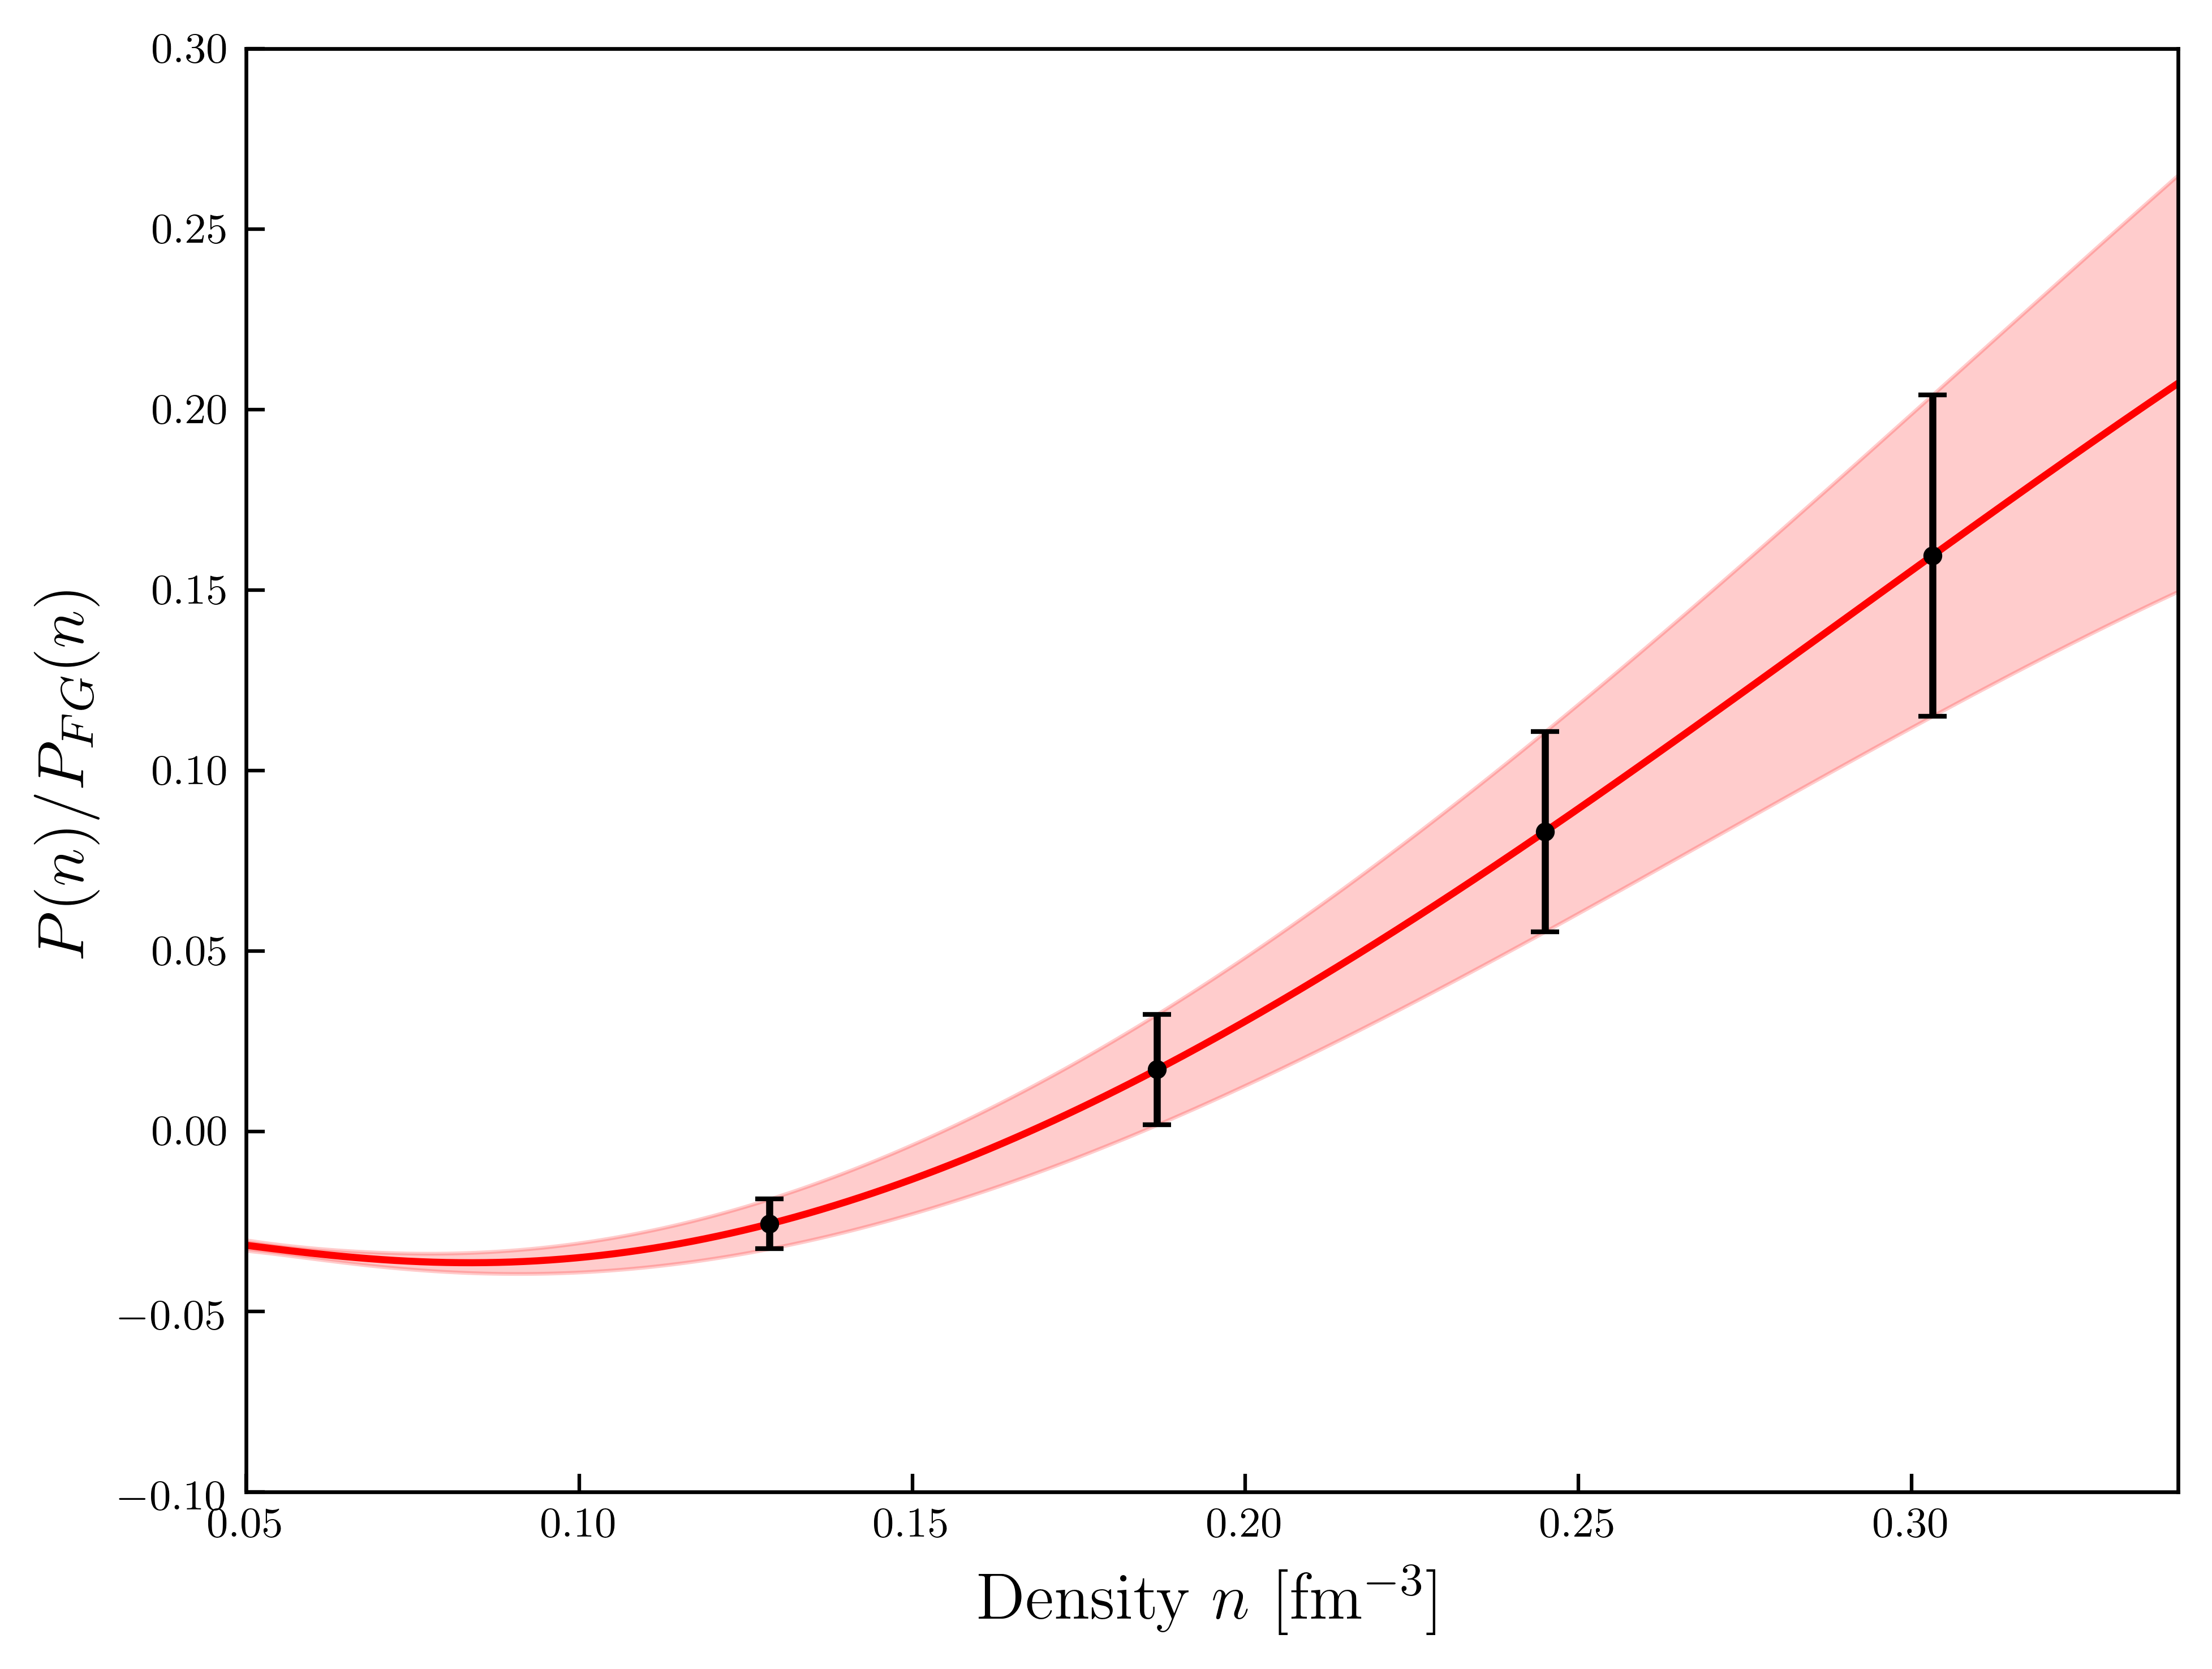

In [9]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_pqcd = "blue"
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xlim(0.05, 0.34)
ax.set_ylim(-0.1, 0.3)
#ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'Density $n$ [fm$^{-3}$]', fontsize=14)
ax.plot(n_xeft, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data['dens'], y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

In [10]:
# set up the kernel
from sklearn.gaussian_process.kernels import Matern
kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
RBF(length_scale=0.9, length_scale_bounds=[0.7,1.2])  # 40n0 => [0.7,1.2] # 20n0 => 1.1
#kernel = C(constant_value=0.6) * RBF(length_scale=1)

X_train = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data_2['mean'].reshape(-1,1)

# set up the class for the GP
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'],  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000)

gp.fit(X_train, y_train, priors=True)  # fit to the data we selected from chiral EFT & pQCD

# try printing the posterior for these parameters given some initial lengthscales
# lengths = np.linspace(0.1, 2.0, 1000)
# lml_val = np.zeros_like(lengths)
# for i in range(len(lengths)):
#     lml_val[i], _ = gp.log_marginal_likelihood(theta=[0.5,lengths[i]], eval_gradient=True, prior=True)
# plt.plot(lengths, lml_val)

GaussianProcessRegressor2dNoise(alpha=array([[4.73404408e-05, 9.62517577e-05, 1.41018972e-04, 1.69844865e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.62517577e-05, 2.34610625e-04, 3.99423156e-04, 5.52219067e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.41018972e-04, 3.99423156e-04, 7.67388554e-04, 1.17898288e-03,...
        1.66689897e-04, 1.36093984e-04, 1.18446966e-04, 1.06700481e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.45051509e-04, 1.18446966e-04, 1.03100428e-04, 9.28845095e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.30649814e-04, 1.06700481e-04, 9.28845095e-05, 8.36870049e-05]]),
                                kernel=1.05**2 * RBF(length_scale=0.9),
                                n_restarts_optimizer=10000)

We can print out the kernel hyperparameters ($\bar{c}$ and $\ell$) below, and see what we get using this kernel.

In [11]:
print(gp.kernel_)

0.891**2 * RBF(length_scale=1.16)


We then use the same kernel to predict at new points in density, and plot our GP result, along with the heavy ion collision contour and the FRG EOS contour.

In [12]:
# conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [14]:
# use the testing density array now for predicting at new locations (also in log space)
#X_chiral = np.log(density_test[:17]).reshape(-1,1)
X = np.log(density_test).reshape(-1,1)
y_pred, y_stdv = gp.predict(X, return_std=True)
_ , y_cov = gp.predict(X, return_cov=True)

# save for plotting later (uncomment to save)
np.savez('../data/eos_data/gp_pressure_40_priors.npz', dens=density_test, mean=y_pred, std=y_stdv)

In [15]:
# check out the covariance matrix
# print(y_cov.shape)
# index_2n0 = np.where([density_test[i] <= 0.05 for i in range(len(density_test))])[0][-1]
# print(density_test[index_2n0])
# index_40n0 = np.where([density_test[i] <= 6.56 for i in range(len(density_test))])[0][-1]

# # covariances
# y_var_2n0 = y_cov[index_2n0, index_2n0]
# y_var_40n0 = y_cov[index_40n0, index_40n0]
# y_cross_2n0_40n0 = y_cov[index_2n0, index_40n0]

# # correlation coefficient
# corr_coeff = y_cross_2n0_40n0 / (np.sqrt(y_var_2n0) * np.sqrt(y_var_40n0))
# print('Correlation coefficient: ', corr_coeff)

In [16]:
# check out the covariance matrix
print(y_cov.shape)
index_2n0 = np.where([density_test[i] <= 0.34 for i in range(len(density_test))])[0][-1]
print([index_2n0])
index_40n0 = np.where([density_test[i] <= 6.56 for i in range(len(density_test))])[0][-1]
index_5n0 = np.where([density_test[i] <= 0.80 for i in range(len(density_test))])[0][-1]

# covariances
y_var_2n0 = y_cov[index_2n0, index_2n0]
y_var_40n0 = y_cov[index_40n0, index_40n0]
y_cross_2n0_40n0 = y_cov[index_2n0, index_40n0]

# covariances between 5n0 and 40n0 here
y_var_5n0 = y_cov[index_5n0, index_5n0]
y_cross_5n0_40n0 = y_cov[index_5n0, index_40n0]

# correlation coefficients
corr_coeff = y_cross_2n0_40n0 / (np.sqrt(y_var_2n0) * np.sqrt(y_var_40n0))
corr_coeff_2 = y_cross_5n0_40n0 / (np.sqrt(y_var_5n0) * np.sqrt(y_var_40n0))
print('Correlation coefficient: ', corr_coeff)
print('Next one: ', corr_coeff_2)

(899, 899)
[15]
Correlation coefficient:  0.005573266897633418
Next one:  0.031182050493480565


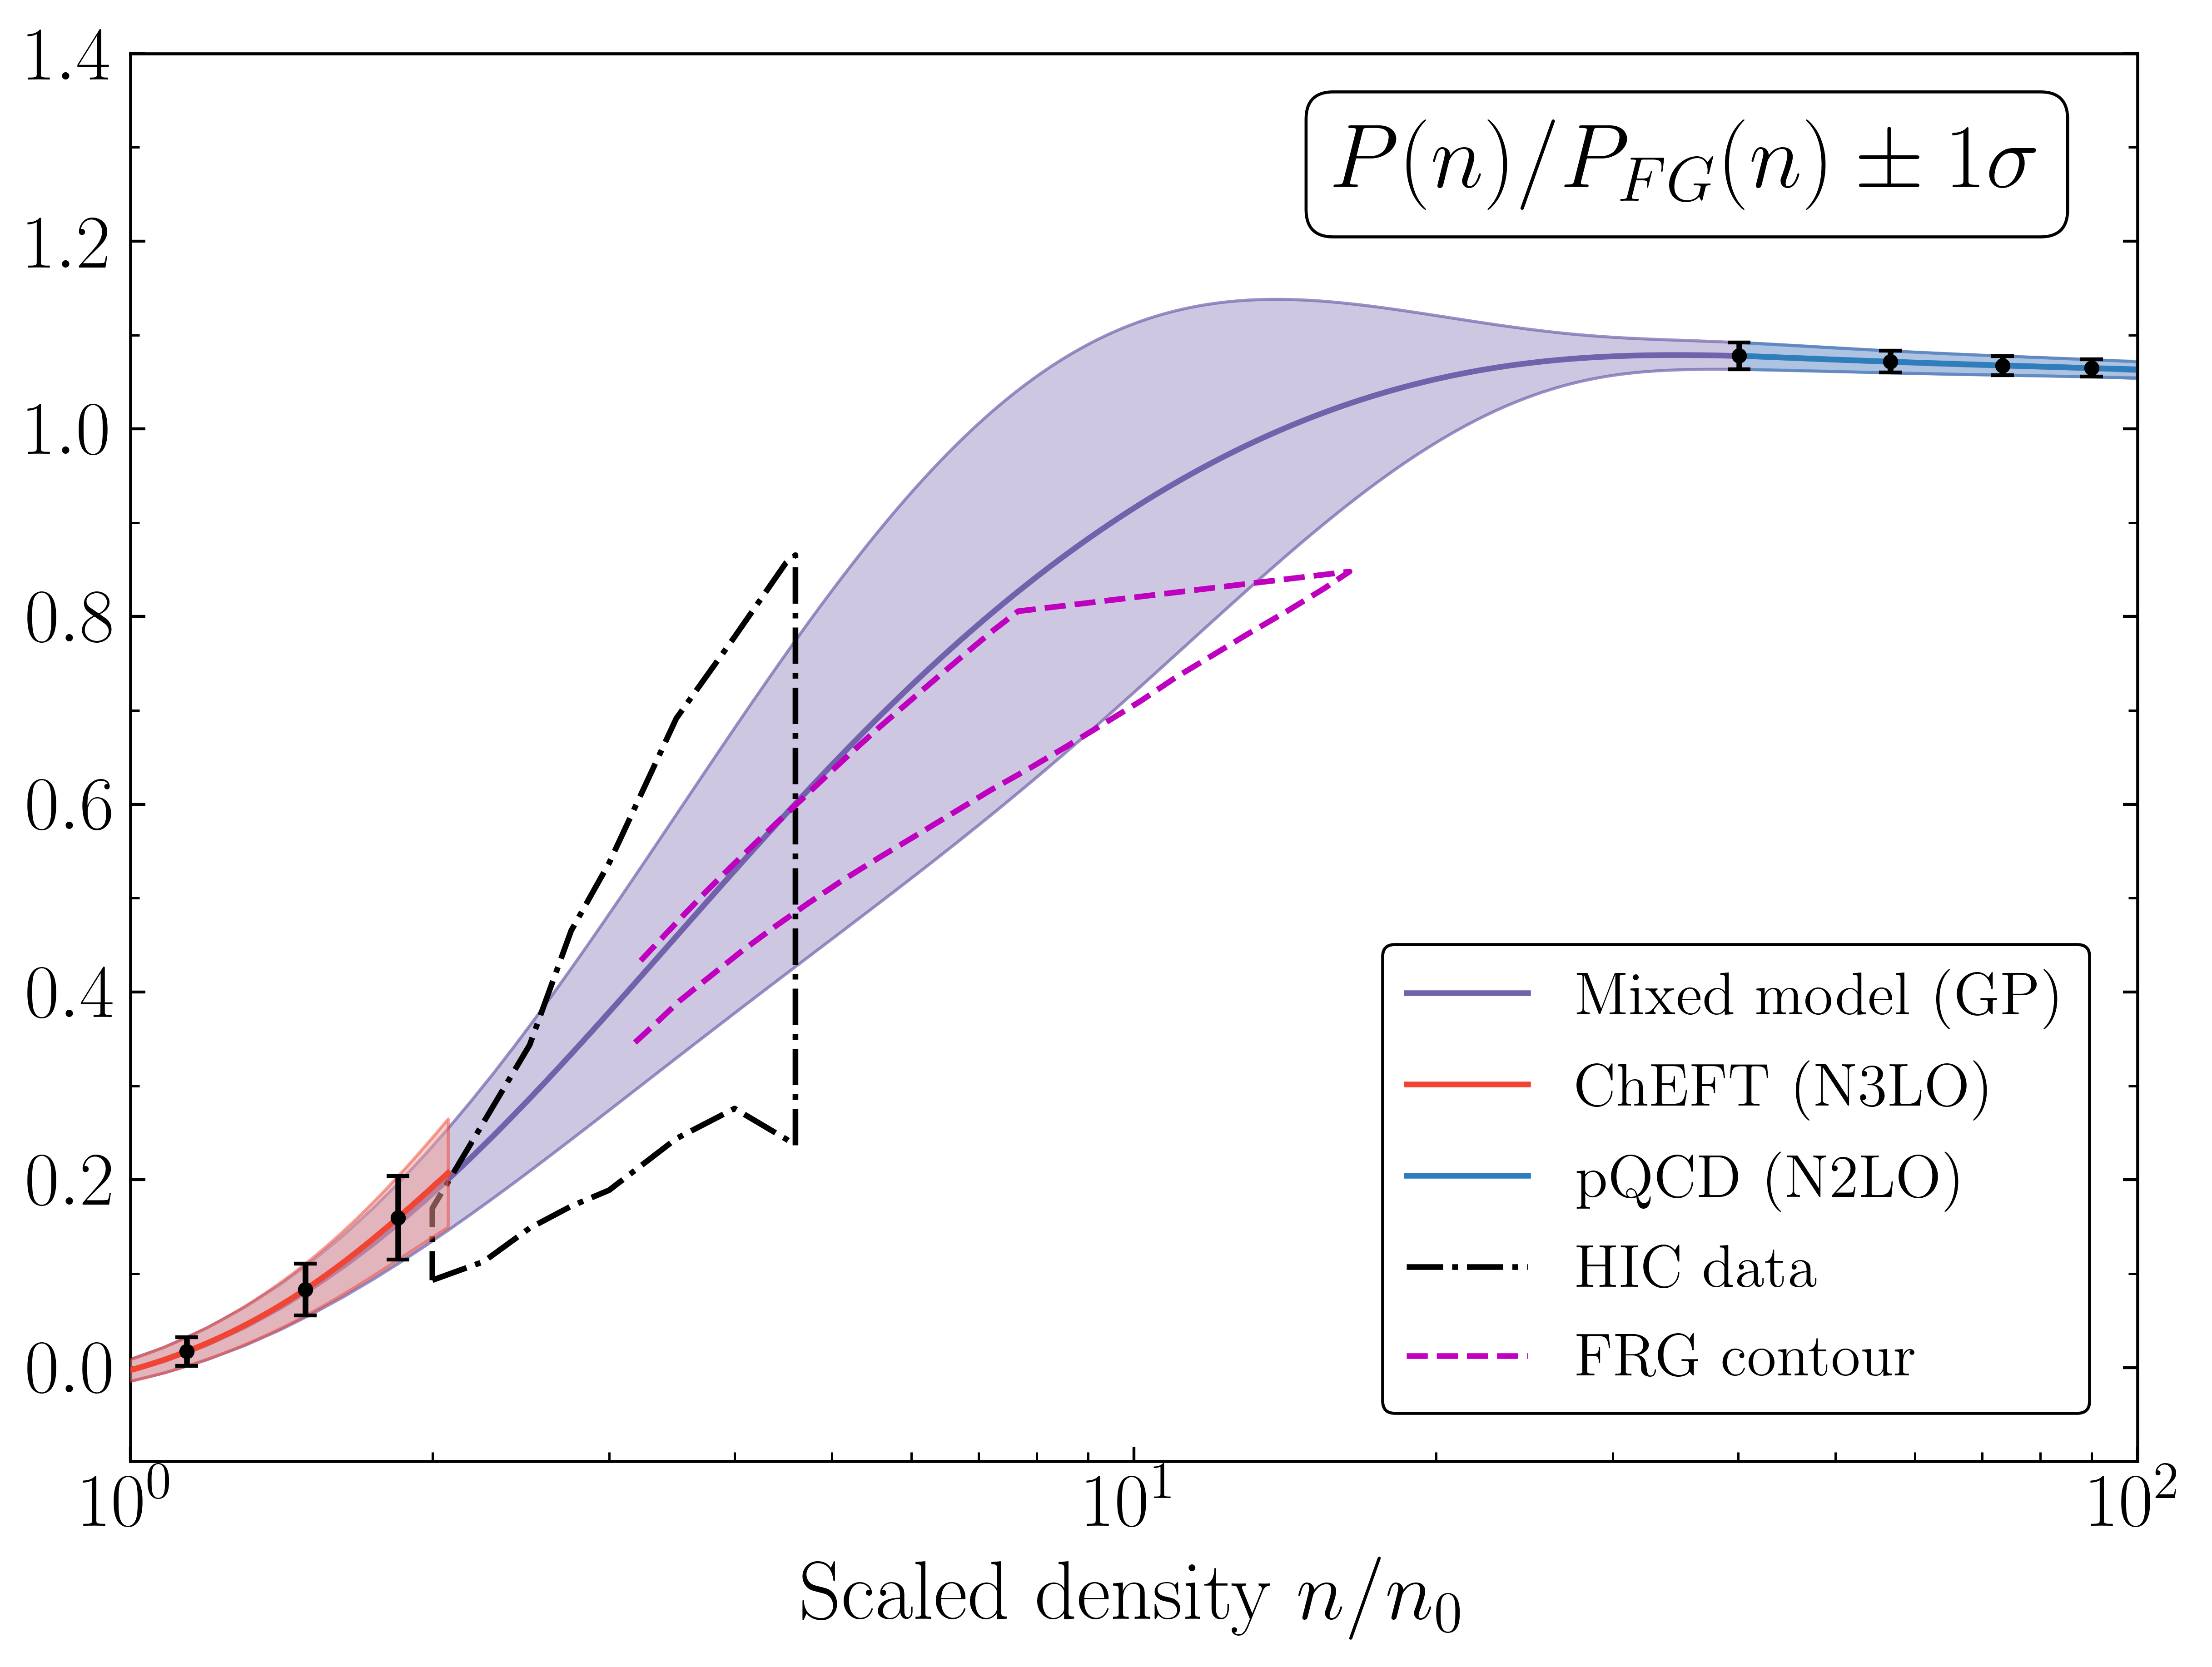

In [17]:
fig, ax = plt.subplots(figsize=(8,6), dpi=600)
ax.set_xlim(1.0, 100.)
ax.set_ylim(-0.1, 1.4)
ax.tick_params(axis='both', which='major', labelsize=20, right=True)
ax.tick_params(axis='both', which='minor', labelsize=20, right=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)
#ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)

# GP result and uncertainty band
ax.plot(density_test/n0, y_pred, c=colors[2], label=r'Mixed model (GP)', zorder=-1)
ax.fill_between(density_test/n0, y_pred-y_stdv, y_pred+y_stdv, facecolor=light_colors[2], \
                edgecolor=colors[2], alpha=0.7, zorder=-2)

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color=colors[0], label=r'ChEFT (N3LO)', zorder=5)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.5, \
                facecolor=light_colors[0], edgecolor=colors[0], zorder=4)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs, zorder=10)
ax.plot(n_pqcd/n0, p_mean_pqcd, color=colors[1], label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.5, \
                facecolor=light_colors[1], edgecolor=colors[1])

# import contours and plot
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')

# unscale FRG
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

plt.legend(loc='lower right', fontsize=16)
#fig.savefig('naive_40n0_gp_model.PNG')
plt.show()

In [18]:
# difference between the two curves
#print(100*np.abs(y_stdv[16] - p_stdv_xeft[-1])/p_stdv_xeft[-1])
#print(p_mean_xeft)
#print(p_stdv_xeft)

In [19]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv[16]

band_pqcd = p_stdv_pqcd[0]
index_pqcd40 = np.where([density_test[i] <= 6.56 for i in range(len(density_test))])[0][-1]
band_gp_pqcd = y_stdv[index_pqcd40]
print('here', band_gp_pqcd)
print('here 2', band_pqcd)
print('Density at chosen point:', density_test[16], 'fm^-3')

# compare for reduction in uncertainty
var_chiral = band_chiral**2.0
print('Chiral variance:', var_chiral)
var_gp = 0.775**2.0
print('Untrained prior GP variance (cbar^2):', var_gp)
var_mm = band_gp**2.0
print('Mixed model variance (post-training):', var_mm)

# combine
combined = var_chiral * var_gp / (var_chiral + var_gp)
print('Calculated combined variance:', combined)

# print out the differences
print('Difference between bands: ', ((band_chiral - band_gp)/(band_chiral))*100)
print('Difference between GP and pQCD: ', (np.abs(band_pqcd - band_gp_pqcd)/band_pqcd)*100)

here 0.014323462189785648
here 2 0.014290284733214993
Density at chosen point: 0.3409899888765294 fm^-3
Chiral variance: 0.003328895599035214
Untrained prior GP variance (cbar^2): 0.6006250000000001
Mixed model variance (post-training): 0.0029710194051575374
Calculated combined variance: 0.0033105472681609093
Difference between bands:  5.528098519178001
Difference between GP and pQCD:  0.23216791820488045


In [20]:
# printing log likelihood vs. lengthscale for this problem
# ell = np.linspace(1e-6, 5.0, 200)
# log_likelihood = []
# for ls in ell:
#     kernel = C(constant_value=0.6) * RBF(length_scale=ls, length_scale_bounds='fixed')
#     gp = GaussianProcessRegressor2dNoise(
#     kernel=kernel,
#     alpha=training_data['cov']  # here is where we input the full covariance matrix from the data
#     )
#     gp.fit(X_train, y_train)
#     log_likelihood.append(gp.log_marginal_likelihood())
    
# plt.plot(ell, np.exp(log_likelihood))
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'Marginal likelihood')
# idx = np.where([i == max(log_likelihood) for i in log_likelihood])[0][0]
# print(ell[idx])

In [21]:
# integrate between lengthscales and see where 68% is
# from scipy.integrate import simpson

# # integrate full distribution
# full_integral = simpson(np.exp(log_likelihood), ell)

# # integrate region I care about only (between 1.65-2.05)
# ind_low = np.where([ell[i] <= 1.65 for i in range(len(ell))])[-1][-1]
# ind_high = np.where([ell[i] <= 2.05 for i in range(len(ell))])[-1][-1] + 1

# part_integral = simpson(np.exp(log_likelihood[ind_low:ind_high+1]), ell[ind_low:ind_high+1])

# print(part_integral/full_integral)

# now produce plots of both cases, 1.65 and 2.05, to see how the BMM curve changes/widens.

Below we print out some values of the pQCD and mixed model EOSs that we use in Table III of our paper (Sec. IV B).

In [22]:
# print out values for Table III
print('GP values: P(n) and 1-sigma uncertainty:')
seldens = 36
from scipy.interpolate import interp1d
gp_mean_interp = interp1d(density_test, y_pred, kind='cubic', fill_value='extrapolate')
print(gp_mean_interp(seldens*0.164)*convert_interp(seldens*0.164))
gp_std_interp = interp1d(density_test, y_stdv, kind='cubic', fill_value='extrapolate')
print(gp_std_interp(seldens*0.164)*convert_interp(seldens*0.164))

# print out pQCD values for Table III
print('\npQCD values: P(n) and 1-sigma uncertainty:')
pqcd_mean_interp = interp1d(data_pqcd['density'][19:], data_pqcd['mean'][19:,2], \
                            kind='linear', fill_value='extrapolate')
print(pqcd_mean_interp(seldens*0.164)*convert_interp(seldens*0.164))
pqcd_std_interp = interp1d(data_pqcd['density'][19:], data_pqcd['std_dev'][19:,2], \
                           kind='linear', fill_value='extrapolate')
print(pqcd_std_interp(seldens*0.164)*convert_interp(seldens*0.164))

GP values: P(n) and 1-sigma uncertainty:
4182.7359573099375
59.51613619271793

pQCD values: P(n) and 1-sigma uncertainty:
4188.945853104595
59.251854726488226


---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="calc_cs2"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density, as we did as well in the pointwise mixing notebook. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{n}^{n_{i}} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(n_{i})}{n_{i}} \right],
$$

where $n_{i}$ is 16.4 fm$^{-3}$, as we will be integrating downwards from pQCD to $\chi$EFT in this approach.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu(n)} \frac{\partial P(n)}{\partial n}.
$$

We have a utility function that runs both the integration and the speed of sound calculation, so we will call that and implement the speed of sound. However, we first need to sample from the GP, since this is the way to best propagate the uncertainties from the pressure to the speed of sound without drastically overestimating them.

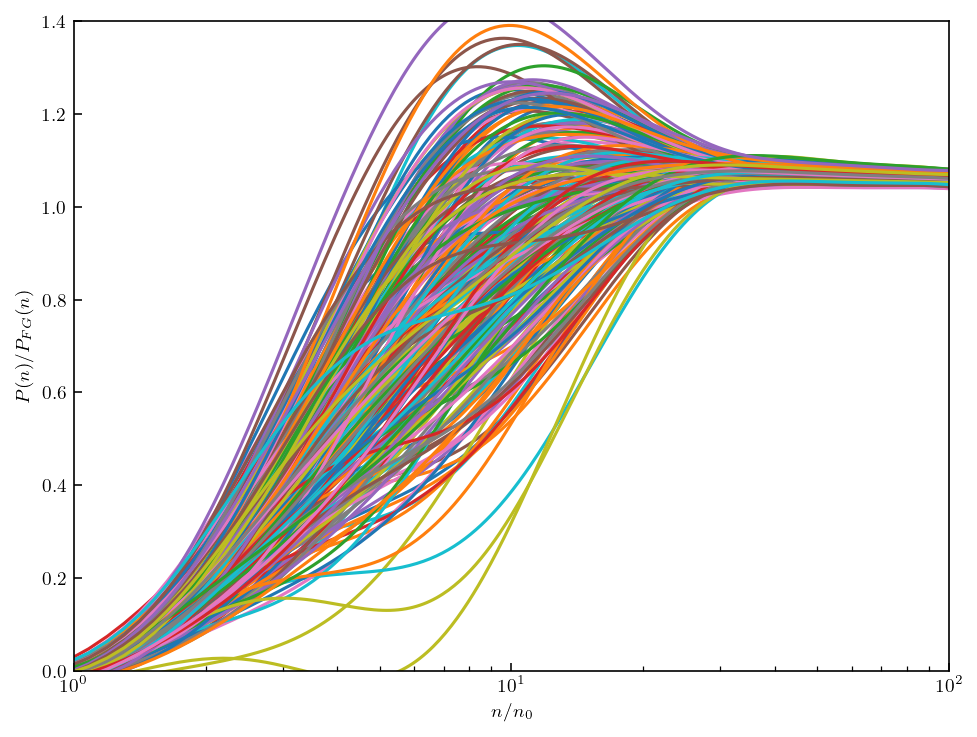

In [23]:
# sample from the pressure GP curve first
samples_data = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=500)

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

(893, 250)
(893, 250)


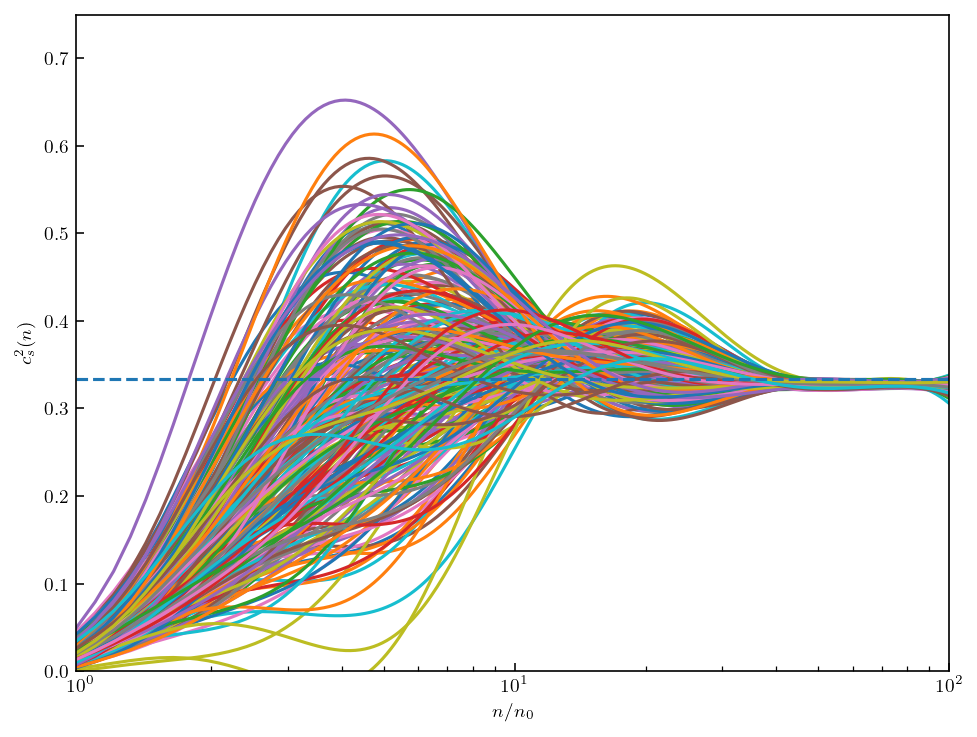

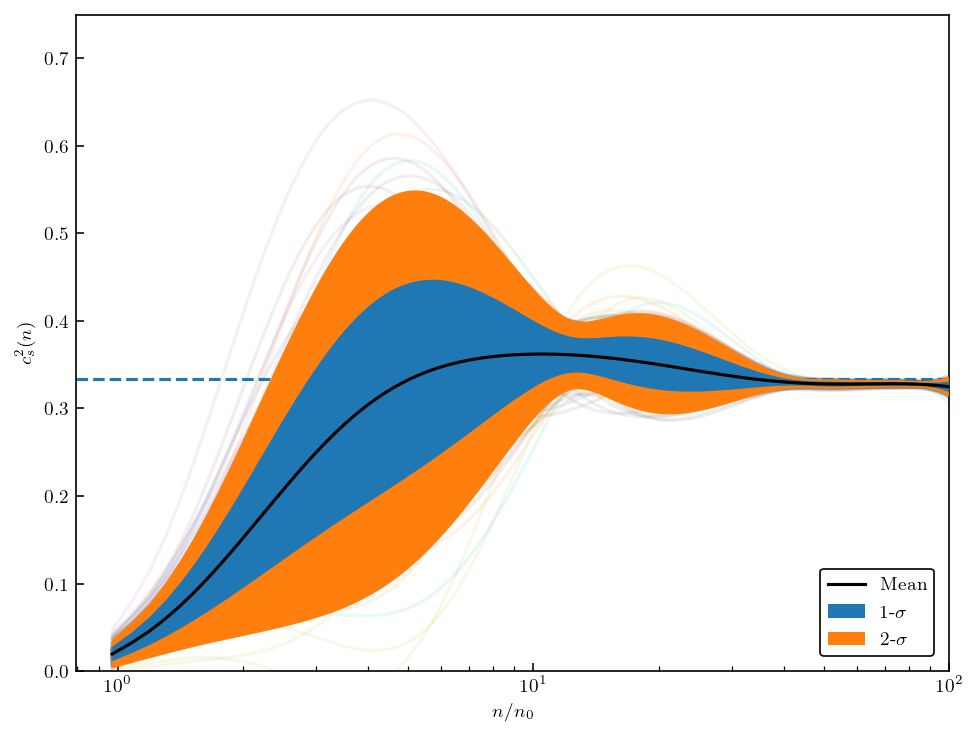

In [24]:
# integrate backward to anchor at pQCD and plot the speed of sound result
pres_samples = samples_data

# run interpolation for FG scaling (needed for determination 
# of P(n) from scaled result)
gp_cs2_convert_arr = convert_interp(density_test)

# unscale the samples from the FG scaling
pres_samples_unscaled = [pres_samples[:,i]*gp_cs2_convert_arr \
                         for i in range(len(np.asarray(pres_samples).T))]

# cut at saturation (or thereabouts; unstable matter under saturation for symmetric)
sat_cut = (np.where([i >= 0.164 for i in density_test])[0][0]) - 1

# pull dict values out and make arrays
gp_mean = y_pred
gp_std = y_stdv

# send to the speed of sound calculation (for interpolation)
pres_dict = {
    'mean': gp_mean[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'std_dev': gp_std[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'samples': np.asarray(pres_samples_unscaled)[:, sat_cut:].T
}

# integrating downwards from pQCD
# (results here from pQCD notebook boundary_conditions function)
en_0 = 49210.54331120984       # BC at 100*n0
en_0_lower = 49079.01210179091 
en_0_upper = 49342.07447863117

# for draws, try new anchor point function
pqcd_class = PQCD(X=1, Nf=2)
edens_0_draw_arr = pqcd_class.anchor_point_edens(np.asarray(pres_samples_unscaled)[:, sat_cut:].T, \
                                                 anchor=density_test[-1])

# make dict of values to send to speed of sound code
edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper,
    'samples': edens_0_draw_arr
}

# call speed of sound function (sampled = True automatically runs the integration downwards)
cs2_sampled, edens_full = speed_of_sound(density_test[sat_cut:], pres_dict, \
                                         edens_dict, sat=False, sampled=True)

# save for plotting later (uncomment to save)
# np.savez('../data/eos_data/cs2_gp_20_priors.npz', dens=density_test[sat_cut:], mean=cs2_sampled['mean'],\
#          std=cs2_sampled['std'], samples=cs2_sampled['samples'])

# dict entries 
cs2_sampled_mean = cs2_sampled['mean']
cs2_sampled_std = cs2_sampled['std']
cs2_sampled_samples = cs2_sampled['samples']

# samples plot
[plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i]) for i in range(len(edens_full))]
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.16/n0, 16.4/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

# mean and std dev band plot
[plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i], alpha=0.1) for i in range(len(edens_full))]
plt.plot(density_test[sat_cut:]/n0, cs2_sampled_mean, 'k', zorder=20, label=r'Mean')
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_sampled_mean-cs2_sampled_std, cs2_sampled_mean+cs2_sampled_std, zorder=12, \
                 label=r'1-$\sigma$')
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_sampled_mean-1.96*cs2_sampled_std, cs2_sampled_mean+1.96*cs2_sampled_std, \
                 label=r'2-$\sigma$', zorder=10)
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.13/n0, 16.4/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.legend(loc='lower right')
plt.show()

Excellent! Now we have our samples, so we can plot the results for $P(n)$ and $c_{s}^{2}(n)$ side-by-side like in Sec. IV of our paper. First we will import the speed of sound data from the $\chi$EFT and pQCD results.

In [25]:
# import the speed of sound data from ChEFT and pQCD
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')

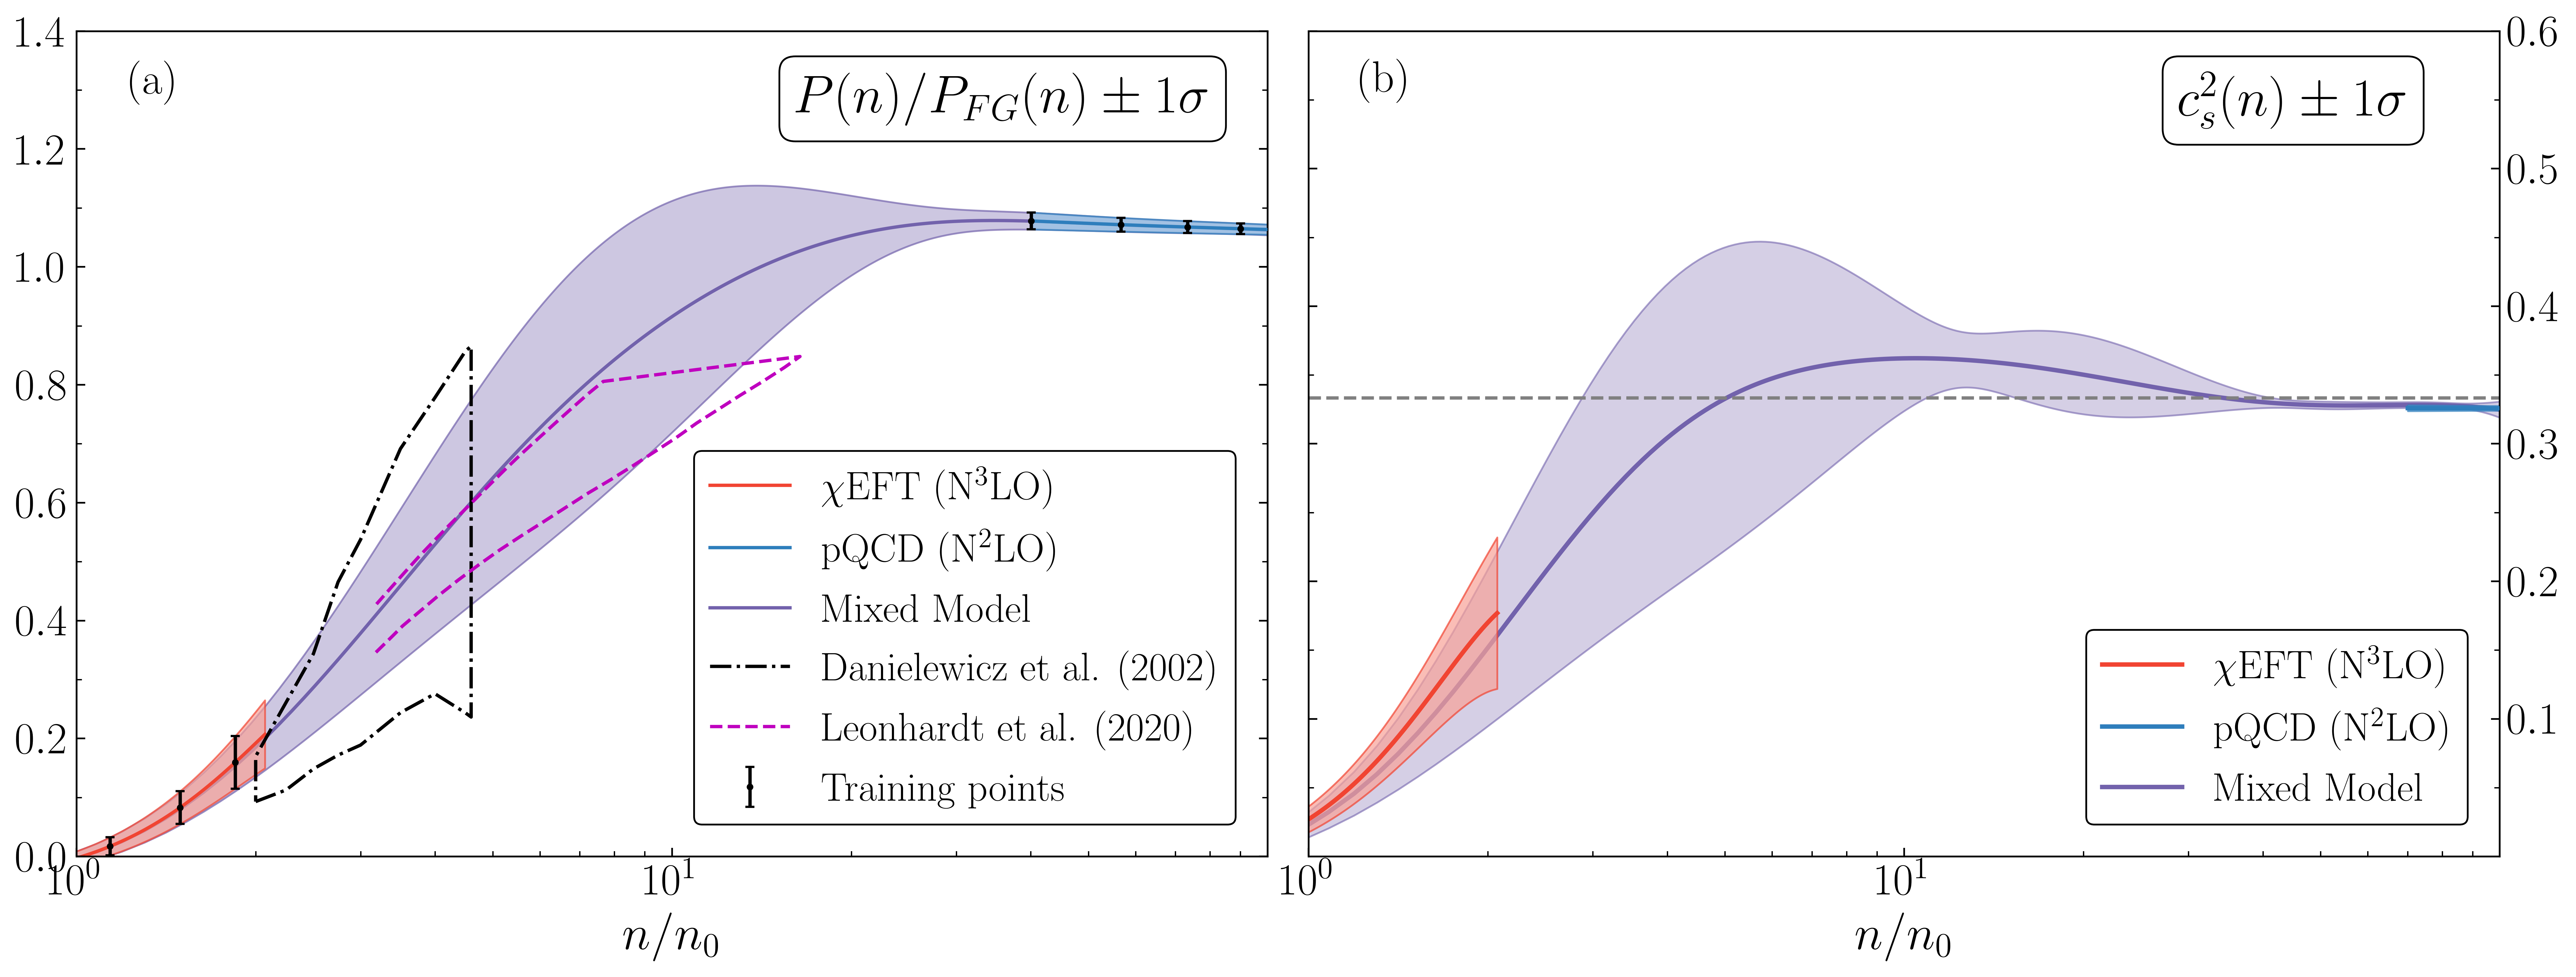

In [26]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density_test/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
#ax[0].text(1.5, 1.15, r'lengthscale = 1.2', ha='left', va='top', fontsize=18)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density_test/n0))
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean'][:,2]
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0].fill_between(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - \
                   1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:], zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0].fill_between(density_test/n0, gp_mean-1.0*gp_std, gp_mean+ \
                   1.0*gp_std,
                       zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density_test/n0, gp_mean, color=colors[2], zorder=-1, label='Mixed Model')
  
# plot FRG and HIC contours
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0].errorbar(training_data["dens"]/n0, training_data["mean"], yerr=training_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(density_test[sat_cut:]/n0, cs2_sampled['mean']-cs2_sampled['std'], \
                   cs2_sampled['mean']+cs2_sampled['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test[sat_cut:]/n0, cs2_sampled['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
#fig.savefig('../plots/new_subplot_results_40n0.PNG', bbox_inches='tight')

In [97]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = cs2_chiral['std'][:,3][-1]
band_gp = cs2_sampled['std'][10]

# print out the differences
print('Difference between bands: ', ((band_chiral - band_gp)/(band_chiral))*100)

Difference between bands:  -8.43426307761757


## Creating the multi-plot figures in the paper

Below is the code we used to generate the 4 panel figure in our paper. 

In [98]:
# Fig. 7 now, in our paper

orders = [0,1,2]

# load in each file of results needed for P(n)
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_cut_20.npz')
data_pqcd_40 = np.load('../data/eos_data/pressure_pqcd_cut_40.npz')
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')
training_data_20 = np.load('../data/eos_data/correlated_training_data_20n0.npz')
training_data_40 = np.load('../data/eos_data/correlated_training_data_40n0.npz')
pressure_gp_20 = np.load('../data/eos_data/gp_pressure_20_priors.npz')
pressure_gp_40 = np.load('../data/eos_data/gp_pressure_40_priors.npz')

In [99]:
# load in each file of results need for cs2(n)
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')
cs2_GP_20 = np.load('../data/eos_data/cs2_gp_20_priors.npz')
cs2_GP_40 = np.load('../data/eos_data/cs2_gp_40_priors.npz')

# set up the orders and labels
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use for chiral, pqcd data
dens_pqcd = data_pqcd['dens']
dens_pqcd_40 = data_pqcd_40['dens']
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean']
mean_pqcd_40 = data_pqcd_40['mean']
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std']
std_dev_pqcd_40 = data_pqcd_40['std']

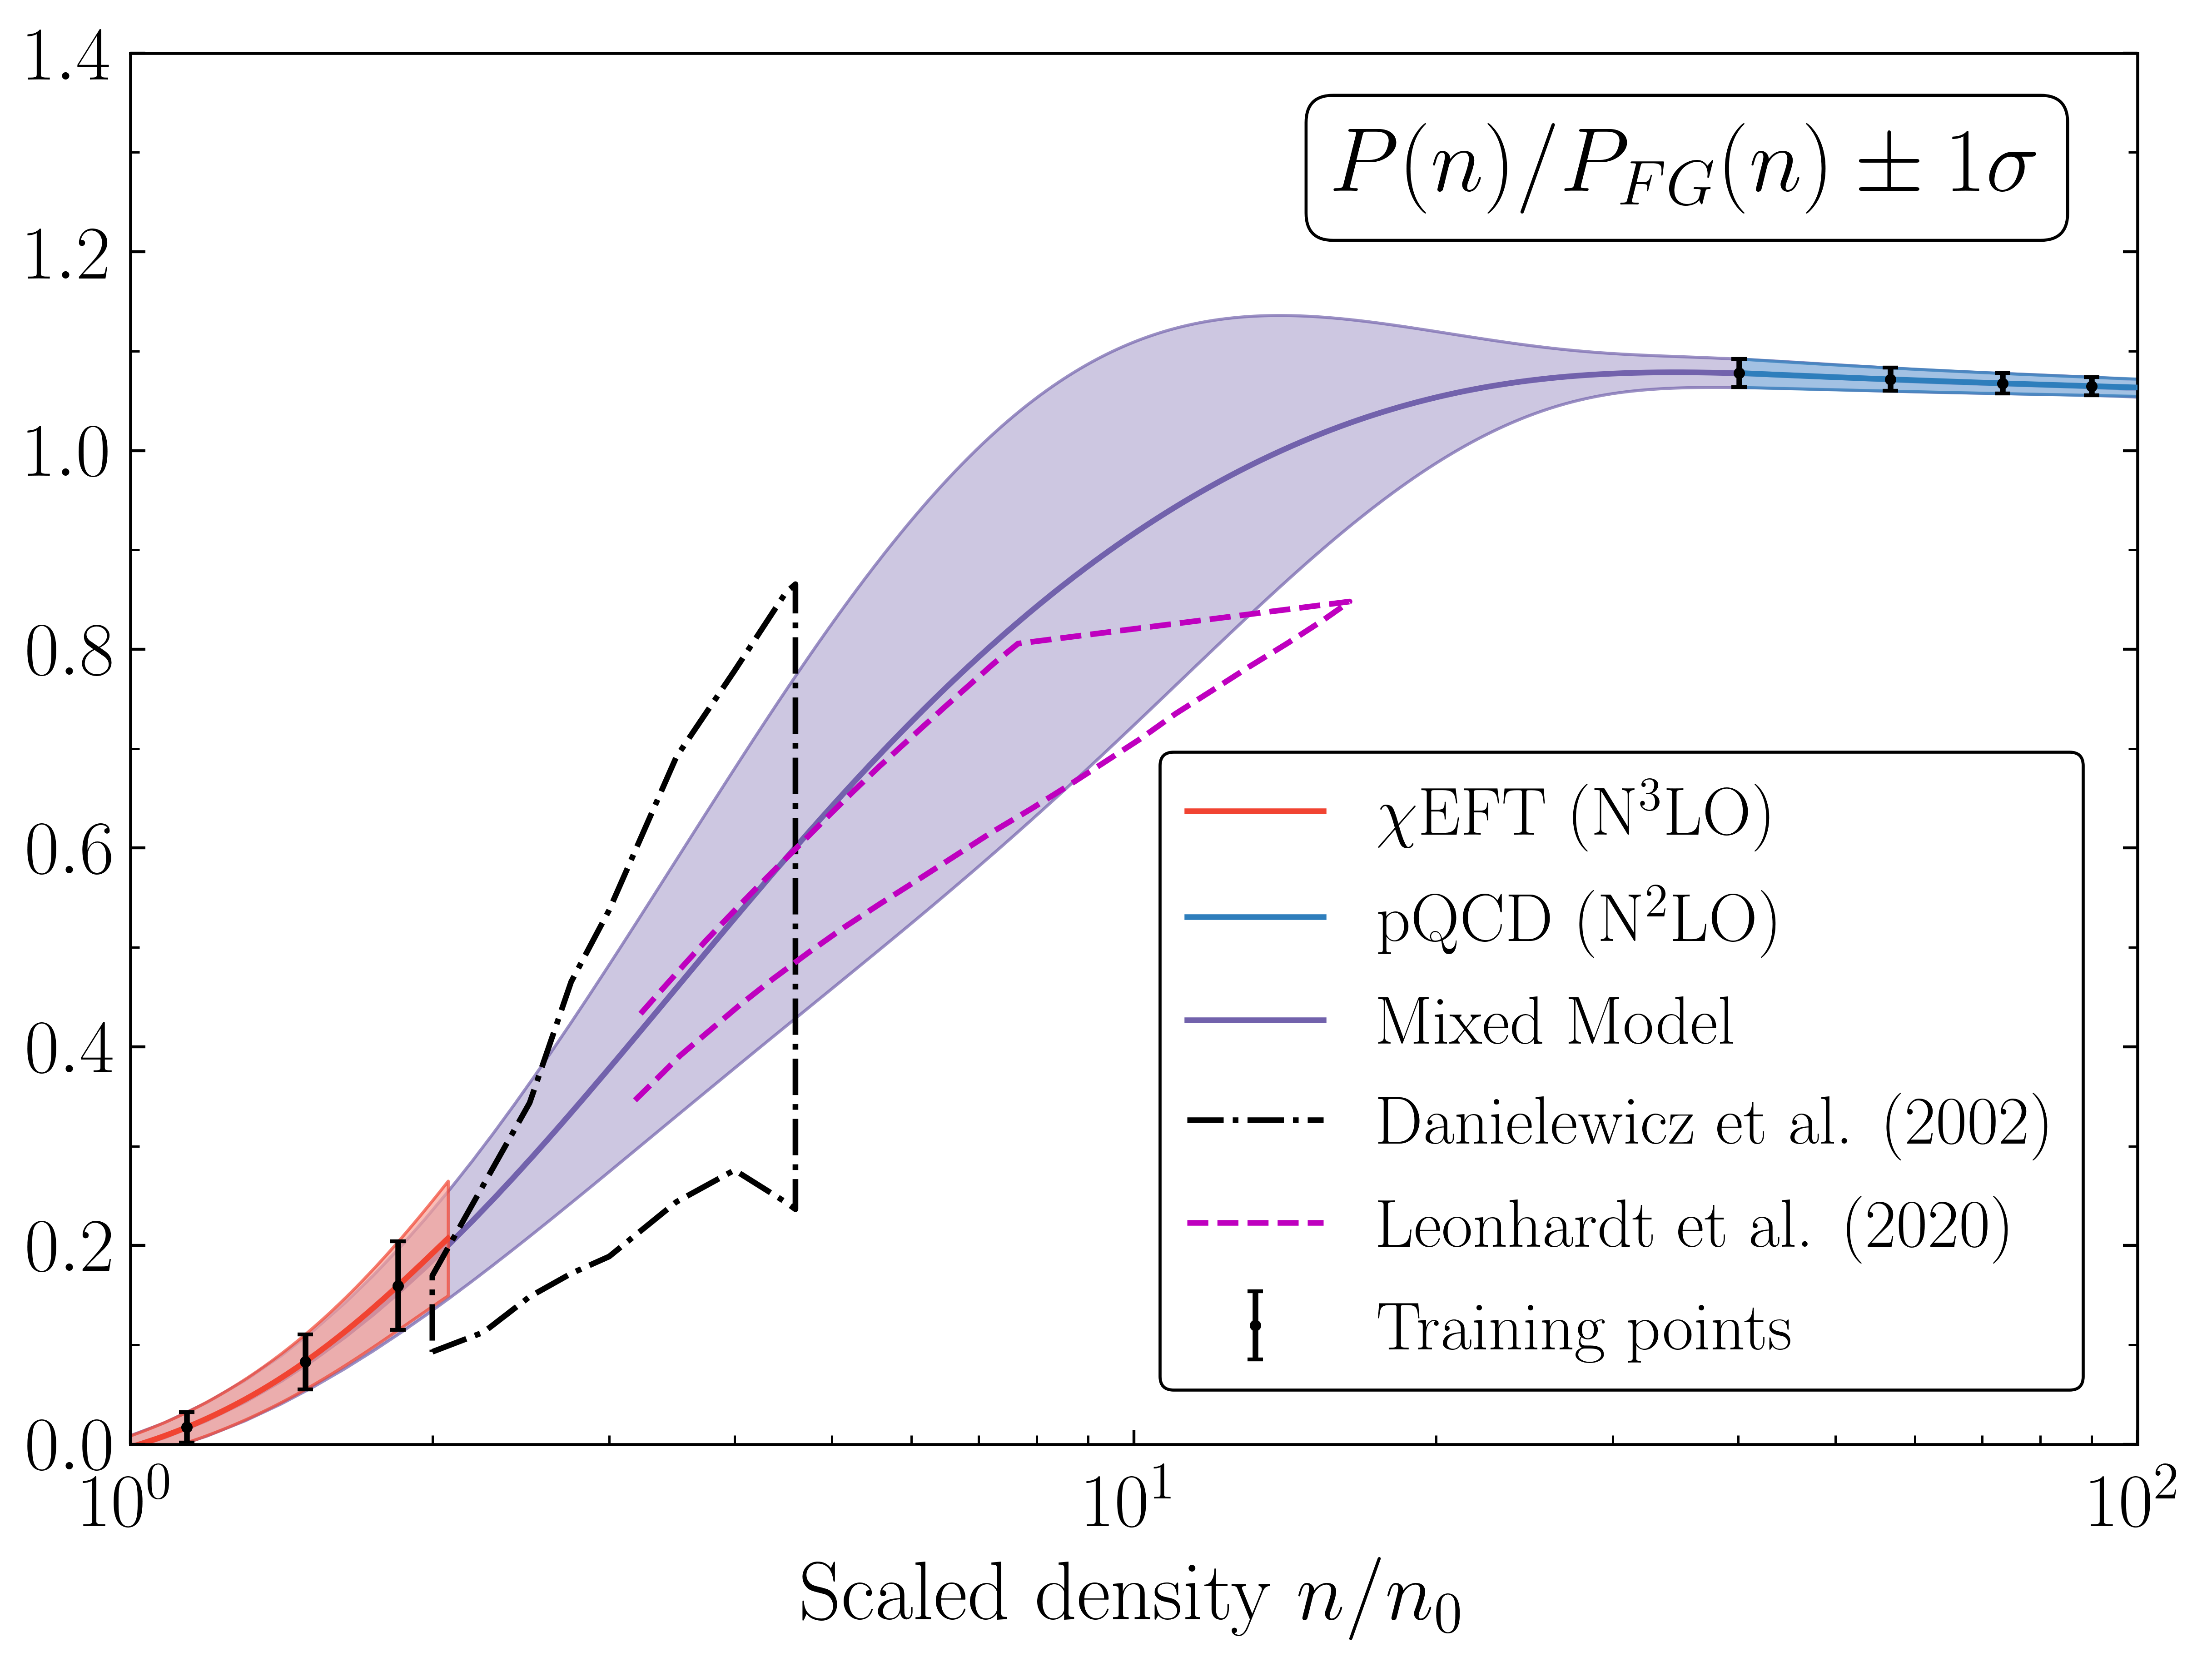

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=600)

# first row
# ax[0].set_xlim(1.00, 100.)
# ax[0].set_ylim(0.0,1.4)
# ax[0].tick_params(axis='x', which='major', labelsize=20, right=True, pad=8)
# ax[0].tick_params(axis='y', which='major', labelsize=20, right=True)
# ax[0].tick_params(axis='x', which='minor', labelsize=20, right=True)
# ax[0].tick_params(axis='y', which='minor', labelsize=20, right=True)
# ax[0].xaxis.set_major_locator(MultipleLocator(10))
# ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
# ax[0].text(
#     80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
#     multialignment='center', zorder=10, fontsize=24,
#     bbox=dict(facecolor='w', boxstyle='round')
# )
# ax[0].text(2.0, 1.35, r'(a) 20$n_{0}$', ha='right', va='top', fontsize=20)
# ax[0].set_xscale('log')

# ### pressure for panel (a) ###

# # model means and uncertainties
# ax[0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
#                    mean_chiral + 1.0*std_dev_chiral, \
#                    facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

# ax[0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

# ax[0].fill_between(dens_pqcd/n0, mean_pqcd - \
#                    1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
#                 facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

# ax[0].plot(dens_pqcd/n0, mean_pqcd, zorder=3, \
#            color=colors[1], label=order_labels[1])

# # PPD band (testing data array)
# ax[0].fill_between(pressure_gp_20['dens']/n0, pressure_gp_20['mean']-1.0*pressure_gp_20['std'],\
#                    pressure_gp_20['mean']+ 1.0*pressure_gp_20['std'], \
#                    zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# # PPD mean (testing data array)
# ax[0].plot(pressure_gp_20['dens']/n0, pressure_gp_20['mean'], color=colors[2], zorder=-1,\
#              label='Mixed Model')
  
# # plot FRG and HIC contours
# ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
#            zorder=10, label='Danielewicz et al. (2002)')
# ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
#            zorder=10, label='Leonhardt et al. (2020)')

# # plot the training points
# ax[0].errorbar(training_data_20["density"]/n0, training_data_20["mean"], yerr=training_data_20["std"], \
#              color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# # legend
# ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

ax.set_xlim(1.00, 100.)
ax.set_ylim(0.0,1.4)
ax.tick_params(axis='x', which='major', labelsize=20, labelleft=False, labelright=True, right=True, pad=8)
ax.tick_params(axis='y', which='major', labelsize=20, labelleft=True, right=True)
ax.tick_params(axis='x', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax.tick_params(axis='y', which='minor', labelsize=20, labelleft=True, right=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)
ax.set_xscale('log')

### pressure for panel (b) ###

# model means and uncertainties
ax.fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax.plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax.fill_between(dens_pqcd_40/n0, mean_pqcd_40 - \
                   1.0*std_dev_pqcd_40, mean_pqcd_40 + 1.0*std_dev_pqcd_40, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax.plot(dens_pqcd_40/n0, mean_pqcd_40, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax.fill_between(pressure_gp_40['dens']/n0, pressure_gp_40['mean']-1.0*pressure_gp_40['std'],\
                   pressure_gp_40['mean']+ 1.0*pressure_gp_40['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax.plot(pressure_gp_40['dens']/n0, pressure_gp_40['mean'], color=colors[2], zorder=-1,\
             label='Mixed Model')
  
# plot FRG and HIC contours
ax.plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax.errorbar(training_data_40["density"]/n0, training_data_40["mean"], yerr=training_data_40["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax.legend(loc='lower right', facecolor='w', fontsize=18)

#fig.savefig('naive_pressure_40n0.PNG')
plt.show()

In [101]:
# now we need to create the skeleton of the figure
fig, ax = plt.subplots(2, 2, figsize=(16,12), dpi=600, sharex='col')

# first row
ax[0,0].set_xlim(1.00, 100.)
ax[0,0].set_ylim(0.0,1.4)
ax[0,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0,0].xaxis.set_major_locator(MultipleLocator(10))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,0].text(2.0, 1.35, r'(a) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,0].set_xscale('log')

### pressure for panel (a) ###

# model means and uncertainties
ax[0,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0,0].fill_between(dens_pqcd/n0, mean_pqcd - \
                   1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0,0].plot(dens_pqcd/n0, mean_pqcd, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0,0].fill_between(pressure_gp_20['dens']/n0, pressure_gp_20['mean']-1.0*pressure_gp_20['std'],\
                   pressure_gp_20['mean']+ 1.0*pressure_gp_20['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0,0].plot(pressure_gp_20['dens']/n0, pressure_gp_20['mean'], color=colors[2], zorder=-1,\
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[0,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0,0].errorbar(training_data_20["density"]/n0, training_data_20["mean"], yerr=training_data_20["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[0,1].set_xlim(1., 100.)
ax[0,1].set_ylim(0.0,0.6)
ax[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,1].text(2.0, 0.58, r'(c) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,1].set_xscale('log')

### speed of sound for panel (b) ###

ax[0,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[0,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[0,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[0,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[0,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[0,1].fill_between(cs2_GP_20['dens']/n0, cs2_GP_20['mean']-cs2_GP_20['std'], \
                     cs2_GP_20['mean']+cs2_GP_20['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[0,1].plot(cs2_GP_20['dens']/n0, cs2_GP_20['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[0,1].legend(loc='lower right', facecolor='w', fontsize=18)

# next row
ax[1,0].set_xlim(1.00, 100.)
ax[1,0].set_ylim(0.0,1.4)
ax[1,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[1,0].tick_params(axis='x', which='major', labelsize=20, pad=8)
ax[1,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[1,0].xaxis.set_major_locator(MultipleLocator(10))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,0].text(2.0, 1.35, r'(b) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,0].set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)
ax[1,0].set_xscale('log')

### pressure for panel (c)

# model means and uncertainties
ax[1,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[1,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[1,0].fill_between(dens_pqcd_40/n0, mean_pqcd_40 - \
                   1.0*std_dev_pqcd_40, mean_pqcd_40 + 1.0*std_dev_pqcd_40, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[1,0].plot(dens_pqcd_40/n0, mean_pqcd_40, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[1,0].fill_between(pressure_gp_40['dens']/n0, pressure_gp_40['mean']-1.0*pressure_gp_40['std'],\
                   pressure_gp_40['mean']+ 1.0*pressure_gp_40['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[1,0].plot(pressure_gp_40['dens']/n0, pressure_gp_40['mean'], color=colors[2], zorder=-1, \
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[1,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[1,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[1,0].errorbar(training_data_40["density"]/n0, training_data_40["mean"], yerr=training_data_40["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[1,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[1,1].set_xlim(1., 100.)
ax[1,1].set_ylim(1e-6,0.6)
ax[1,1].xaxis.set_major_locator(MultipleLocator(10))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].tick_params(axis='x', which='major', labelsize=20, labelleft=False, labelright=True, right=True, pad=8)
ax[1,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,1].text(2.0, 0.58, r'(d) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,1].set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)
ax[1,1].set_xscale('log')

### speed of sound for panel (d) ###

ax[1,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[1,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[1,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1,1].fill_between(cs2_GP_40['dens']/n0, cs2_GP_40['mean']-cs2_GP_40['std'], \
                     cs2_GP_40['mean']+cs2_GP_40['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1,1].plot(cs2_GP_40['dens']/n0, cs2_GP_40['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1,1].legend(loc='lower right', facecolor='w', fontsize=18)

#fig.savefig('../plots/joint_subplot_curvewise_priors.PNG')
plt.show()

Alexandra Semposki, 01 April 2024.